In [3]:
import sqlite3
import pandas as pd

conn = sqlite3.connect("data/trades.db")
df = pd.read_sql_query("SELECT * FROM trades ORDER BY timestamp", conn, parse_dates=["timestamp"])
conn.close()

# Quick peek
df.head()

,id,timestamp,symbol,strategy,side,price,amount,cost,reason
0,1,2025-05-23 18:33:59.098243,SOL/USDT,RsiStrategy,buy,179.82,0.055611,9.999999,None
1,2,2025-05-23 18:53:58.896951,SOL/USDT,RsiStrategy,sell,178.62,0.055611,9.933265,trailing-stop
2,3,2025-05-23 19:08:58.896126,SOL/USDT,RsiStrategy,buy,179.67,0.055658,9.999999,None
3,4,2025-05-23 19:23:58.914072,SOL/USDT,RsiStrategy,sell,179.76,0.055658,10.005008,time-cap
4,5,2025-05-23 20:43:58.869882,SOL/USDT,RsiStrategy,buy,177.51,0.056335,9.999999,None


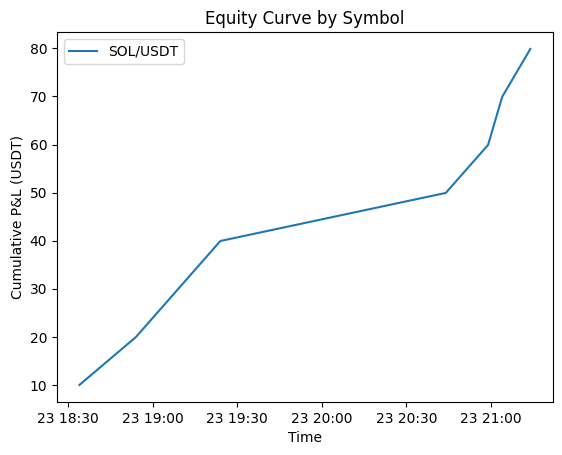

In [4]:
import matplotlib.pyplot as plt

# cumulative P&L by symbol
df["cum_pnl"] = df.groupby("symbol")["cost"].cumsum()

plt.figure()
for sym, grp in df.groupby("symbol"):
    plt.plot(grp["timestamp"], grp["cum_pnl"], label=sym)
plt.legend()
plt.title("Equity Curve by Symbol")
plt.xlabel("Time")
plt.ylabel("Cumulative P&L (USDT)")
plt.show()


In [5]:
summary = df.groupby(["symbol","strategy"])["cost"] \
            .agg(total_pnl="sum", trades="count") \
            .reset_index()
summary


,symbol,strategy,total_pnl,trades
0,SOL/USDT,RsiStrategy,79.888079,8
